#**MESSAGE PASSING INTERFACE (AULA 3)**

### **COMUNICAÇÃO DE GRUPO EM MPI**

Nas aulas passadas, examinamos a comunicação ponto a ponto, que é a comunicação entre dois processos. Nesta aula, estudaremos os mecanismos de comunicação coletiva em MPI. A **comunicação coletiva** é um método de comunicação que envolve a participação de todos os processos em um comunicador.

Novamente, vamos reinstalar o simgrid e fazer o download do modelos de clusters:

In [4]:
!apt install simgrid

[sudo] password for user: 


In [5]:
!git clone https://framagit.org/simgrid/simgrid-template-smpi.git

Cloning into 'simgrid-template-smpi'...
remote: Enumerating objects: 482, done.
remote: Counting objects: 100% (482/482), done.
remote: Compressing objects: 100% (338/338), done.
remote: Total 482 (delta 181), reused 434 (delta 139), pack-reused 0
Receiving objects: 100% (482/482), 967.28 KiB | 885.00 KiB/s, done.
Resolving deltas: 100% (181/181), done.


Uma das coisas a lembrar sobre a comunicação coletiva é que ela implica um ponto de sincronização entre os processos. Isso significa que todos os processos devem atingir um ponto em seu código antes que possam começar a executar novamente.

Antes de entrar em detalhes sobre as rotinas de comunicação coletiva, vamos examinar a sincronização com mais detalhes. Acontece que o MPI possui uma função especial dedicada à sincronização de processos:

**MPI_Barrier(MPI_Comm communicator)**

O nome da função é bastante descritivo - a função forma uma barreira e nenhum processo no comunicador pode ultrapassar a barreira até que todos chamem a função. Imagine que o eixo horizontal representa a execução do programa e os círculos representam diferentes processos:

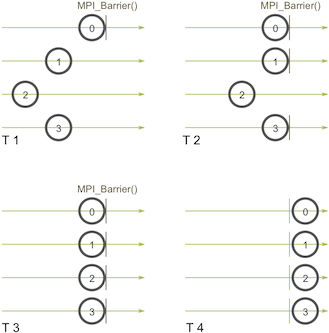

O processo zero primeiro chama MPI_Barrier no primeiro instante (T 1). Enquanto o processo zero está parado na barreira, o processo um e três eventualmente o fazem (T 2). Quando o processo dois finalmente chega à barreira (T 3), todos os processos iniciam a execução novamente (T 4).

Lembre-se sempre de que todas as chamadas coletivas que você fizer são sincronizadas. Em outras palavras, se você não conseguir concluir com êxito um MPI_Barrier, também não poderá concluir com êxito nenhuma chamada coletiva. Se você tentar chamar MPI_Barrier ou outras rotinas coletivas sem garantir que todos os processos no comunicador também o chamem, seu programa ficará ocioso. Isso pode ser muito confuso para iniciantes, então tome cuidado!

### **BROADCASTING (TRANSMISSÃO) EM MPI**

Uma transmissão é uma das técnicas padrão de comunicação coletiva. Durante uma transmissão, um processo envia os mesmos dados para todos os processos em um comunicador. Um dos principais usos da transmissão é enviar a entrada do usuário para um programa paralelo ou enviar parâmetros de configuração para todos os processos.

O padrão de comunicação de uma transmissão é da seguinte forma:

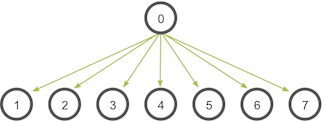

Neste exemplo, o processo zero é o processo-raiz e possui a cópia inicial dos dados. Todos os outros processos recebem a cópia dos dados.

Em MPI, a transmissão pode ser realizada usando MPI_Bcast. O protótipo da função é mostrado a seguir:

**MPI_Bcast(
    void* data,
    int count,
    MPI_Datatype datatype,
    int root,
    MPI_Comm communicator)**

Embora o processo raiz e os processos receptores executem tarefas diferentes, todos eles chamam a mesma função MPI_Bcast. Quando o processo raiz (no nosso exemplo era o processo zero) chamar MPI_Bcast, a variável de dados será enviada para todos os outros processos. Quando todos os processos receptores chamarem MPI_Bcast, a variável data será preenchida com os dados do processo raiz.

A transmissão pode ser implementada com as primitivas MPI_Send e MPI_Recv, conforme mostrado no programa abaixo:

In [6]:
%%writefile mybcast.c

#include <stdio.h>
#include <stdlib.h>
#include <mpi.h>

void my_bcast(void* data, int count, MPI_Datatype datatype, int root,
              MPI_Comm communicator) {
  int world_rank;
  MPI_Comm_rank(communicator, &world_rank);
  int world_size;
  MPI_Comm_size(communicator, &world_size);

  if (world_rank == root) {
    // If we are the root process, send our data to everyone
    int i;
    for (i = 0; i < world_size; i++) {
      if (i != world_rank) {
        MPI_Send(data, count, datatype, i, 0, communicator);
      }
    }
  } else {
    // If we are a receiver process, receive the data from the root
    MPI_Recv(data, count, datatype, root, 0, communicator, MPI_STATUS_IGNORE);
  }
}

int main(int argc, char** argv) {
  MPI_Init(NULL, NULL);

  int world_rank;
  MPI_Comm_rank(MPI_COMM_WORLD, &world_rank);

  int data;
  if (world_rank == 0) {
    data = 100;
    printf("Process 0 broadcasting data %d\n", data);
    my_bcast(&data, 1, MPI_INT, 0, MPI_COMM_WORLD);
  } else {
    my_bcast(&data, 1, MPI_INT, 0, MPI_COMM_WORLD);
    printf("Process %d received data %d from root process\n", world_rank, data);
  }

  MPI_Finalize();
}

Writing mybcast.c


In [7]:
!smpicc mybcast.c -o mybcast

In [8]:
!smpirun -np 16 -platform simgrid-template-smpi/cluster_crossbar.xml -hostfile simgrid-template-smpi/cluster_hostfile ./mybcast

[0.000000] [xbt_cfg/INFO] Configuration change: Set 'smpi/privatization' to '1'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'surf/precision' to '1e-9'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'network/model' to 'SMPI'
[0.000000] [smpi_kernel/INFO] You did not set the power of the host running the simulation.  The timings will certainly not be accurate.  Use the option "--cfg=smpi/host-speed:<flops>" to set its value.  Check https://simgrid.org/doc/latest/Configuring_SimGrid.html#automatic-benchmarking-of-smpi-code for more information.
Process 0 broadcasting data 100
Process 15 received data 100 from root process
Process 14 received data 100 from root process
Process 13 received data 100 from root process
Process 12 received data 100 from root process
Process 11 received data 100 from root process
Process 10 received data 100 from root process
Process 9 received data 100 from root process
Process 8 received data 100 from root process
Process 7 received data 100 from 

Acredite ou não, nossa função é realmente muito ineficiente! Imagine que cada processo tenha apenas um link de rede de entrada/saída. Nossa função é usar apenas um link de rede do processo zero para enviar todos os dados. Uma implementação mais inteligente é um algoritmo de comunicação baseado em árvore que pode usar mais links de rede disponíveis de uma só vez. Por exemplo:

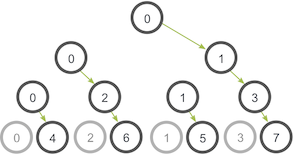

O processo zero começa com os dados e os envia para o processo um. Semelhante ao nosso exemplo anterior, o processo zero também envia os dados para o processo dois no segundo estágio. A diferença com este exemplo é que o processo um agora está ajudando o processo raiz encaminhando os dados para o processo três. Durante o segundo estágio, duas conexões de rede estão sendo utilizadas por vez. A utilização da rede dobra em cada estágio subseqüente da árvore de comunicação até que todos os processos tenham recebido os dados.

A implementação do MPI_Bcast utiliza um algoritmo de transmissão em árvore semelhante para uma boa utilização da rede. Abaixo temos o código anterior comparado com a chamada de MPI_Bcast:

In [9]:
%%writefile mpibcast.c

#include <stdio.h>
#include <stdlib.h>
#include <mpi.h>
#include <assert.h>

void my_bcast(void* data, int count, MPI_Datatype datatype, int root,
              MPI_Comm communicator) {
  int world_rank;
  MPI_Comm_rank(communicator, &world_rank);
  int world_size;
  MPI_Comm_size(communicator, &world_size);

  if (world_rank == root) {
    // If we are the root process, send our data to everyone
    int i;
    for (i = 0; i < world_size; i++) {
      if (i != world_rank) {
        MPI_Send(data, count, datatype, i, 0, communicator);
      }
    }
  } else {
    // If we are a receiver process, receive the data from the root
    MPI_Recv(data, count, datatype, root, 0, communicator, MPI_STATUS_IGNORE);
  }
}

int main(int argc, char** argv) {
  if (argc != 3) {
    fprintf(stderr, "Usage: compare_bcast num_elements num_trials\n");
    exit(1);
  }

  int num_elements = atoi(argv[1]);
  int num_trials = atoi(argv[2]);

  MPI_Init(NULL, NULL);

  int world_rank;
  MPI_Comm_rank(MPI_COMM_WORLD, &world_rank);

  double total_my_bcast_time = 0.0;
  double total_mpi_bcast_time = 0.0;
  int i;
  int* data = (int*)malloc(sizeof(int) * num_elements);
  assert(data != NULL);

  for (i = 0; i < num_trials; i++) {
    // Time my_bcast
    // Synchronize before starting timing
    MPI_Barrier(MPI_COMM_WORLD);
    total_my_bcast_time -= MPI_Wtime();
    my_bcast(data, num_elements, MPI_INT, 0, MPI_COMM_WORLD);
    // Synchronize again before obtaining final time
    MPI_Barrier(MPI_COMM_WORLD);
    total_my_bcast_time += MPI_Wtime();

    // Time MPI_Bcast
    MPI_Barrier(MPI_COMM_WORLD);
    total_mpi_bcast_time -= MPI_Wtime();
    MPI_Bcast(data, num_elements, MPI_INT, 0, MPI_COMM_WORLD);
    MPI_Barrier(MPI_COMM_WORLD);
    total_mpi_bcast_time += MPI_Wtime();
  }

  // Print off timing information
  if (world_rank == 0) {
    printf("Data size = %d, Trials = %d\n", num_elements * (int)sizeof(int),
           num_trials);
    printf("Avg my_bcast time = %lf\n", total_my_bcast_time / num_trials);
    printf("Avg MPI_Bcast time = %lf\n", total_mpi_bcast_time / num_trials);
  }

  free(data);
  MPI_Finalize();
}

Writing mpibcast.c


In [10]:
!smpicc mpibcast.c -o mpibcast

Vamos, agora, rodar um experimento comparativo entre a nossa implementação de transmissão e a do MPI, enviando 10 vezes um vetor de 100000 números do processo-mestre para os processos-escravos:

In [13]:
!smpirun -np 16 -platform simgrid-template-smpi/cluster_crossbar.xml -hostfile simgrid-template-smpi/cluster_hostfile ./mpibcast 100000 10

[0.000000] [xbt_cfg/INFO] Configuration change: Set 'smpi/privatization' to '1'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'surf/precision' to '1e-9'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'network/model' to 'SMPI'
[0.000000] [smpi_kernel/INFO] You did not set the power of the host running the simulation.  The timings will certainly not be accurate.  Use the option "--cfg=smpi/host-speed:<flops>" to set its value.  Check https://simgrid.org/doc/latest/Configuring_SimGrid.html#automatic-benchmarking-of-smpi-code for more information.
Data size = 400000, Trials = 10
Avg my_bcast time = 0.068692
Avg MPI_Bcast time = 0.018464


### **EXERCÍCIO 1**

Varie o número de processadores, trials e números de elementos do código anterior e compare os resultados.

In [15]:
lista_processadores = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

for i in lista_processadores:
    print('-'*20)
    print("Processadores: ", i)
    !smpirun -np {i} -platform simgrid-template-smpi/cluster_crossbar.xml -hostfile simgrid-template-smpi/cluster_hostfile ./mpibcast 100000 10

--------------------
Processadores:  1
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'smpi/privatization' to '1'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'surf/precision' to '1e-9'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'network/model' to 'SMPI'
[0.000000] [smpi_kernel/INFO] You did not set the power of the host running the simulation.  The timings will certainly not be accurate.  Use the option "--cfg=smpi/host-speed:<flops>" to set its value.  Check https://simgrid.org/doc/latest/Configuring_SimGrid.html#automatic-benchmarking-of-smpi-code for more information.
Data size = 400000, Trials = 10
Avg my_bcast time = 0.000000
Avg MPI_Bcast time = 0.000000
--------------------
Processadores:  2
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'smpi/privatization' to '1'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'surf/precision' to '1e-9'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'network/model' to 'SMPI'
[0.000000] [smpi_kernel/INFO] You

In [17]:
lista_trials = [1, 10, 100, 1000, 10000, 100000, 1000000]

for i in lista_trials:
    print('-'*20)
    print("Tries: ", i)
    !smpirun -np 16 -platform simgrid-template-smpi/cluster_crossbar.xml -hostfile simgrid-template-smpi/cluster_hostfile ./mpibcast 100000 {i}

--------------------
Tries:  1
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'smpi/privatization' to '1'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'surf/precision' to '1e-9'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'network/model' to 'SMPI'
[0.000000] [smpi_kernel/INFO] You did not set the power of the host running the simulation.  The timings will certainly not be accurate.  Use the option "--cfg=smpi/host-speed:<flops>" to set its value.  Check https://simgrid.org/doc/latest/Configuring_SimGrid.html#automatic-benchmarking-of-smpi-code for more information.
Data size = 400000, Trials = 1
Avg my_bcast time = 0.068692
Avg MPI_Bcast time = 0.018464
--------------------
Tries:  10
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'smpi/privatization' to '1'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'surf/precision' to '1e-9'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'network/model' to 'SMPI'
[0.000000] [smpi_kernel/INFO] You did not set the

In [1]:
lista_tamanho = [1000, 10000, 100000, 1000000]

for i in lista_tamanho:
    print('-'*20)
    print("Tamanho: ", i)
    !smpirun -np 16 -platform simgrid-template-smpi/cluster_crossbar.xml -hostfile simgrid-template-smpi/cluster_hostfile ./mpibcast {i} 10

--------------------
Tamanho:  1000
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'smpi/privatization' to '1'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'surf/precision' to '1e-9'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'network/model' to 'SMPI'
[0.000000] [smpi_kernel/INFO] You did not set the power of the host running the simulation.  The timings will certainly not be accurate.  Use the option "--cfg=smpi/host-speed:<flops>" to set its value.  Check https://simgrid.org/doc/latest/Configuring_SimGrid.html#automatic-benchmarking-of-smpi-code for more information.
Data size = 4000, Trials = 10
Avg my_bcast time = 0.000883
Avg MPI_Bcast time = 0.001291
--------------------
Tamanho:  10000
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'smpi/privatization' to '1'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'surf/precision' to '1e-9'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'network/model' to 'SMPI'
[0.000000] [smpi_kernel/INFO] You did no

### **EXERCÍCIO 2**

Considere o código abaixo, que produz uma aproximação de PI usando as primitivas MPI_Bcast e MPI_Reduce. Neste código:

*   o mestre lê o número de intervalos e o envia a todos os escravos
*   os escravos calculam as suas aproximações para PI usando a Fórmula de Leibiniz (subtotal)
*   o mestre reduz o resultado usando uma soma dos subtotais

Com base nesta descrição, complete (em ****) o código fornecido:



In [2]:
%%writefile pi.c

#include <stdio.h>
#include <math.h>
#include <mpi.h>

/* We define pi here so we can check and see how accurate our computation is. */
#define PI 3.141592653589793238462643

int main(int argc, char **argv) {
    MPI_Init(&argc, &argv);

    int processes, myid;
    MPI_Comm_size(MPI_COMM_WORLD, &processes);
    MPI_Comm_rank(MPI_COMM_WORLD, &myid);

    
    int intervals;
    if (myid == 0) {
        printf("Number of intervals: ");
        fflush(stdout);
        scanf("%d", &intervals);
    }

    double time1 = MPI_Wtime();

    MPI_Bcast(&intervals, 1, MPI_INT, 0, MPI_COMM_WORLD);

    int count = intervals / processes;
    int start = count * myid;
    int end = count * myid + count;

    int i;
    double subtotal, total = 0;
    for (i = start; i < end; ++i) {
        subtotal += pow(-1, i) / (2 * i + 1);
    }

    MPI_Reduce(&subtotal, &total, 1, MPI_DOUBLE, MPI_SUM, 0, MPI_COMM_WORLD);

    double time2 = MPI_Wtime();

    if (myid == 0) {
        total = total * 4;
        printf("Result:   %.10lf\n", total);
        printf("Accuracy: %.10lf\n", PI - total);
        printf("Time:     %.10lf\n", time2 - time1);
    }

    MPI_Finalize();
}

Writing pi.c


In [3]:
!smpicc pi.c -o pi -lm

/home/user/log-comp-davirvs/supercomputacao/aula20/pi.c: In function ‘main’:
/home/user/log-comp-davirvs/supercomputacao/aula20/pi.c:21:9: warning: ignoring return value of ‘scanf’, declared with attribute warn_unused_result [-Wunused-result]
   21 |         scanf("%d", &intervals);
      |         ^~~~~~~~~~~~~~~~~~~~~~~


In [5]:
!smpirun -np 128 -platform simgrid-template-smpi/cluster_crossbar.xml -hostfile simgrid-template-smpi/cluster_hostfile ./pi

[0.000000] [xbt_cfg/INFO] Configuration change: Set 'smpi/privatization' to '1'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'surf/precision' to '1e-9'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'network/model' to 'SMPI'
[0.000000] [smpi_kernel/INFO] You did not set the power of the host running the simulation.  The timings will certainly not be accurate.  Use the option "--cfg=smpi/host-speed:<flops>" to set its value.  Check https://simgrid.org/doc/latest/Configuring_SimGrid.html#automatic-benchmarking-of-smpi-code for more information.
Number of intervals: ^C
[node-0.simgrid.org:0:(1) 0.000000] [simix_kernel/INFO] CTRL-C pressed. The current status will be displayed before exit (disable that behavior with option 'debug/verbose-exit').
[node-0.simgrid.org:0:(1) 0.000000] [simix_kernel/INFO] 128 processes are still running, waiting for something.
[node-0.simgrid.org:0:(1) 0.000000] [simix_kernel/INFO] Legend of the following listing: "Process <pid> (<name>@<host>): <st

### **EXERCÍCIO 3**

Após o estudo de todas as primitivas de MPI realizadas até aqui, proponha o esquema de uma implementação para resolver o problema da mochila.

**DESAFIO:** implemente o esquema em MPI.

In [ ]:
# PROPONHA SUA IMPLEMENTAÇÃO AQUI